In [1]:
image_path = 'C:\\Users\\jonat\\Downloads\\C16_10.8_C_01.tif'
ext_model_path = 'C:\\Users\\jonat\\PycharmProjects\\Titanium_Find_Contour_U-Net\\unet_model'
int_model_path = 'C:\\Users\\jonat\\PycharmProjects\\Titanium_Find_Contour_U-Net\\internal_smaller_mask_unet_model'

In [2]:
# Convert the image from format tif to png
from PIL import Image

im = Image.open(image_path)
im.save(image_path[:-3] + 'png')
image_path = image_path[:-3] + 'png'

In [3]:
import cv2
import os

img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, width = gray.shape
img = img[0:width, 0:width]
# replace the image with the new one
cv2.imwrite(image_path, img)

True

In [4]:
import numpy as np
import tensorflow as tf

def get_contour(mask: np.ndarray):
     # Apply thresholding
    ret, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    # sDefine structuring element (MORPH_RECT)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    # Erosion using MORPH_RECT structuring element
    erosion= cv2.erode(thresh, kernel, iterations=1)
    # Dilate using MORPH_RECT structuring element
    dilation = cv2.dilate(erosion, kernel, iterations=1)
    # Find contour using the eroded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Find the contour with the largest area
    contour = max(contours, key=cv2.contourArea)
    return contour

def predict_mask(img, model):
    # Predict the mask
    img = cv2.resize(img, (128, 128))
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1)
    img = img / 255
    pred = model.predict(img)
    pred = tf.argmax(pred, axis=-1)
    pred = pred[..., tf.newaxis]
    pred = tf.squeeze(pred)
    pred = pred.numpy()
    pred = pred.astype(np.uint8) * 255
    return pred

In [5]:
def get_heatmap(img, contour):
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # create a mask with the contour
    mask = np.zeros(img_grey.shape, np.uint8)
    cv2.drawContours(mask, [contour], -1, (255, 255, 255), -1, cv2.LINE_AA)
    #######################
    out = np.zeros_like(img)
    out[mask == 255] = img[mask == 255]
    img_color = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
    ######################
    img_grey = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(img_grey, (13,13), 0)
    #edges = cv2.Canny(blur, 50, 150)
    # Run Sobel filter on the original image
    sobelx = cv2.Sobel(blur, cv2.CV_8U, 1, 0, ksize=5)
    sobely = cv2.Sobel(blur, cv2.CV_8U, 0, 1, ksize=5)
    # Find the magnitude of the gradient
    sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)
    # Normalize the image
    sobel_magnitude = sobel_magnitude/sobel_magnitude.max()*255
    # Convert to uint8
    sobel_magnitude = np.uint8(sobel_magnitude)

    window_size = 201 # Odd number only
    window_step = 10

    heat_map_sobel = np.zeros(sobel_magnitude.shape, dtype=np.uint8)

    # pad the images with zeros
    sobel_c = np.pad(sobel_magnitude, int((window_size-1)/2), mode='constant', constant_values=0)
    mask_metal_c = np.pad(mask, int((window_size-1)/2), mode='constant', constant_values=0)

    for y in range(0, sobel_c.shape[0], window_step):
        for x in range(0, sobel_c.shape[1], window_step):
            window = sobel_c[y:y+window_size, x:x+window_size]
            mask_metal_window = mask_metal_c[y:y+window_size, x:x+window_size]/255
            if mask_metal_window.sum() == 0 or mask_metal_window[(int((window_size - 1) / 2)), (int((window_size - 1) / 2))] == 0:
                heat_map_sobel[y:y+window_size, x:x+window_size] = 0
            else:
                heat_map_sobel[y:y+window_step, x:x+window_step] = np.sum(window)/mask_metal_window.sum()

    heat_map_sobel = cv2.equalizeHist(heat_map_sobel)

    # # apply a threshold to remove low-intensity values
    # threshold = 50
    # heat_map_sobel[heat_map_sobel < threshold] = 0

    # Save the image with color map
    heat_map_sobel_tmp = heat_map_sobel.copy()
    heat_map_color_sobel = cv2.applyColorMap(heat_map_sobel_tmp, cv2.COLORMAP_JET)
    heat_map_color_sobel_rgb = cv2.applyColorMap(heat_map_color_sobel, cv2.COLOR_BGR2RGB)
    return heat_map_color_sobel

In [6]:
def crop_image(img, contour):
    # Create a mask with the contour
    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask, [contour], -1, (255, 255, 255), -1, cv2.LINE_AA)
    # Apply the mask to the image
    img = cv2.bitwise_and(img, mask)
    return img

In [7]:
# Load the models
ex_cnt_model = tf.keras.models.load_model(ext_model_path)
in_cnt_model = tf.keras.models.load_model(int_model_path)

In [8]:
# Load the original image
original_img = cv2.imread(image_path)

# Predict the external mask
ext_mask = predict_mask(original_img, ex_cnt_model)

# Crop the image using the external mask
ext_contour = get_contour(ext_mask)
ext_contour = ext_contour * (original_img.shape[0] / 128)
ext_contour = ext_contour.astype(np.int32)
cropped_img = crop_image(original_img, ext_contour)

1/1 [==============================] - 1s 1s/step


In [9]:
# Load the heatmap using the get_heatmap function
heatmap_img = get_heatmap(original_img, ext_contour)

In [10]:
# Find the internal mask
int_mask = predict_mask(heatmap_img, in_cnt_model)

# Find the internal contour
int_contour = get_contour(int_mask)
int_contour = int_contour * (original_img.shape[0] / 128)

1/1 [==============================] - 1s 1s/step


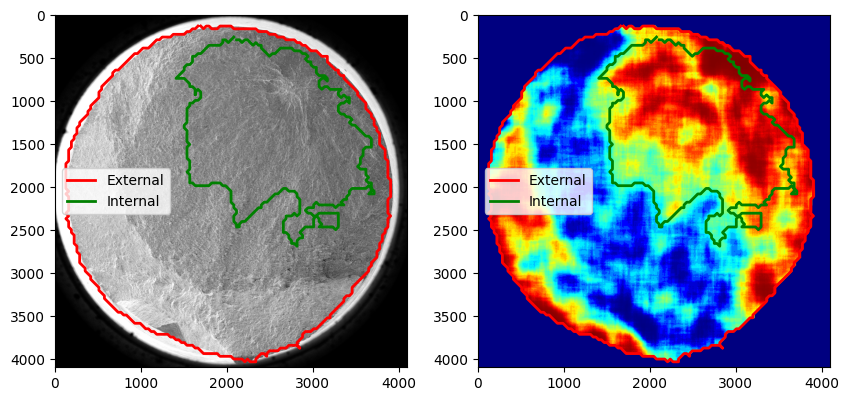

In [11]:
# plot the internal contour and external contour, on the original image and on the heatmap, and add a legend to distinguish betwwen external and internal
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
ax[0].imshow(original_img_rgb)
ax[0].plot(ext_contour[:, 0, 0], ext_contour[:, 0, 1], linewidth=2, color='red', label='External')
ax[0].plot(int_contour[:, 0, 0], int_contour[:, 0, 1], linewidth=2, color='green', label='Internal')
ax[0].legend()
heatmap_img_rgb = cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB)
ax[1].imshow(heatmap_img_rgb)
ax[1].plot(ext_contour[:, 0, 0], ext_contour[:, 0, 1], linewidth=2, color='red', label='External')
ax[1].plot(int_contour[:, 0, 0], int_contour[:, 0, 1], linewidth=2, color='green', label='Internal')
ax[1].legend()
plt.show()

In [12]:
# Save the image with the contours
import os

save_path = os.path.dirname(image_path)
save_name = os.path.basename(image_path)
save_name = save_name[:-4] + '_contours.png'
save_path = os.path.join(save_path, save_name)
fig.savefig(save_path, dpi=300)

Major axis (b): 1542.0 pixels
Minor axis (a): 2137.0 pixels
Radius (D): 3961.44 pixels
Farthest distance (h): 1068.72 pixels


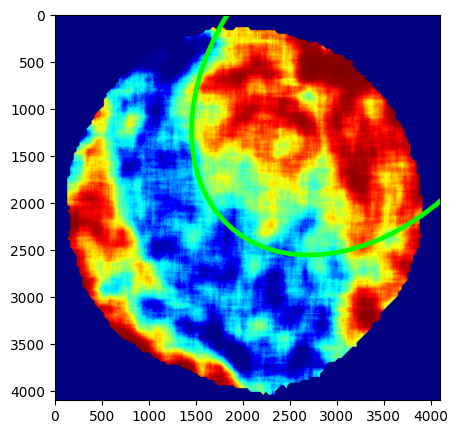

In [17]:
import cv2
import numpy as np
from shapely.geometry import Polygon

def read_image(file_path):
    return cv2.imread(file_path)

def find_center_of_mass(contour):
    # Find the center of mass of the contour
    hull = cv2.convexHull(contour)
    ellipse = cv2.fitEllipse(hull)
    (x, y), (MA, ma), angle = ellipse
    return (int(x), int(y))

def find_center_of_mass2(contour):
    # Find the center of mass of the contour
    M = cv2.minEnclosingCircle(contour)
    return (int(M[0][0]), int(M[0][1]))

def calculate_vector(center1, center2):
    return (center2[0] - center1[0], center2[1] - center1[1])

def is_point_near_line(point, line_start, line_end, eps1):
    # Convert tuples to numpy arrays
    point = np.array(point)
    line_start = np.array(line_start)
    line_end = np.array(line_end)

    # Calculate the directional vector of the line
    line_vec = line_end - line_start

    # Calculate the vector from the start of the line to the point
    point_vec = point - line_start

    # Calculate the cross product and the norm
    cross_prod = np.cross(line_vec, point_vec)
    norm_line_vec = np.linalg.norm(line_vec)

    # Calculate the distance from the point to the line
    distance = np.linalg.norm(cross_prod) / norm_line_vec

    # Check if the distance is within the threshold
    return abs(distance) <= eps1

def find_points_near_line(points, line_start, line_end, eps1):
    step=0.1
    max_eps=100
    # Initialize an empty list to store points near the line
    points_near_line = []

    # Temporary variable for the current eps1 value
    current_eps = eps1

    # Loop until at least one point is found or max_eps is reached
    while len(points_near_line) < 1000  and current_eps <= max_eps:
        # Iterate through each point in the list
        for point in points:
            # Check if the point is near the line
            if is_point_near_line(point, line_start, line_end, current_eps):
                # If the point is near the line, add it to the list
                points_near_line.append(point)

        # Increase current_eps for the next iteration
        current_eps += step

    # Return the list of points near the line as a numpy array
    return np.array(points_near_line)

def is_point_on_left_or_right_side(point, line_start, line_end):
    # Convert tuples to numpy arrays
    point = np.array(point)
    line_start = np.array(line_start)
    line_end = np.array(line_end)

    # Calculate the vector representing the original line
    original_line_vector = line_end - line_start

    # Calculate the orthogonal line vector (rotate original line by 90 degrees)
    orthogonal_line_vector = np.array([-original_line_vector[1], original_line_vector[0]])

    # Define the end point of the new line, extending the orthogonal line from line_start
    new_line_end = line_start + orthogonal_line_vector

    # Calculate the vector from the start of the new line to the point
    point_vector = point - line_start

    # Calculate the vector representing the new line
    new_line_vector = new_line_end - line_start

    # Calculate the cross product (in 2D, it's a scalar)
    cross_prod = np.cross(new_line_vector, point_vector)

    # Determine the side based on the sign of the cross product
    if cross_prod > 0:
        return 'left'
    else:
        return 'right'

def find_farthest_point(contour, center, axis_angle):
    """Find the farthest point on the contour from the center along a specified axis."""
    farthest_distance = 0
    for point in contour:
        # Project each point onto the specified axis
        vector = np.array(point[0]) - np.array(center)
        axis_vector = np.array([np.cos(np.radians(axis_angle)), np.sin(np.radians(axis_angle))])
        distance = np.dot(vector, axis_vector)
        farthest_distance = max(farthest_distance, abs(distance))
    return farthest_distance

def adjust_ellipse(contour, new_center, vector, step_size=1, max_iterations=1000):
    new_center = new_center[0]
    # Fit initial ellipse
    ellipse = cv2.fitEllipse(contour)
    (x, y), (MA, ma), angle = ellipse
    # use the vector to find the angle of rotation, and if angle is negative, add 180 degrees
    # if np.arctan2(vector[1], vector[0]) < 0:
    #     # use vector to find the angle of rotation
    #     angle = 0 + np.degrees(np.arctan2(vector[1], vector[0]))
    # else:
    #    angle = 180 + np.degrees(np.arctan2(vector[1], vector[0]))

    angle = np.degrees(np.arctan2(vector[1], vector[0]))

    # Calculate the farthest point on the contour from the center along the specified axis
    farthest_distance = find_farthest_point(contour, new_center, angle)

    # Calculate new major and minor axes lengths
    new_major_axis = ma * (ma / MA)
    new_minor_axis = farthest_distance  * 2

    # Update the ellipse with the new parameters
    ellipse = (new_center, (new_minor_axis, new_major_axis), angle)

    return ellipse, farthest_distance

def find_ellipse(in_cnt, ex_cnt):
    ex_cnt_center = find_center_of_mass2(ex_cnt)
    in_cnt_center = find_center_of_mass(in_cnt)

    vector = calculate_vector(ex_cnt_center, in_cnt_center)

    # Find points near the line
    eps1 = 0.1
    points_near_line = find_points_near_line(ex_cnt, ex_cnt_center, in_cnt_center, eps1)

    # Find points on the left and right side of the line
    left_points = []
    right_points = []
    for point in points_near_line:
        if is_point_on_left_or_right_side(point, ex_cnt_center, in_cnt_center) == 'left':
            left_points.append(point)
        else:
            right_points.append(point)

    left_points = np.array(left_points)
    right_points = np.array(right_points)

    # Check if the center of mass of the internal contour is on the left or right side of the line
    side = is_point_on_left_or_right_side(in_cnt_center, ex_cnt_center, in_cnt_center)
    if side == 'left':
        points = left_points
    else:
        points = right_points

    sample_point = points[0]

    ellipse, farthest_distance = adjust_ellipse(in_cnt, sample_point, vector)

    return ellipse, farthest_distance

int_contour = int_contour.astype(np.int32)
ext_contour = ext_contour.astype(np.int32)

ellipse, farthest_distance = find_ellipse(int_contour, ext_contour)
ellipse = (tuple(map(int, ellipse[0])), tuple(map(int, ellipse[1])), ellipse[2])
ellipse_img = heatmap_img.copy()
cv2.ellipse(ellipse_img, ellipse, (0, 255, 0), 50)
radius = cv2.minEnclosingCircle(ext_contour)[1]


# Add a description to the image with the ellipse major and minor axes lengths outside image
text = 'Major axis (b): ' + str(round(ellipse[1][1] / 2, 2)) + ' pixels'
text += '\nMinor axis (a): ' + str(round(ellipse[1][0] / 2, 2)) + ' pixels'
text += '\nRadius (D): ' + str(round(radius * 2, 2)) + ' pixels'
text += '\nFarthest distance (h): ' + str(round(farthest_distance / 2.0, 2)) + ' pixels'
print(text)


fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ellipse_img = cv2.cvtColor(ellipse_img, cv2.COLOR_BGR2RGB)
plt.imshow(ellipse_img)
plt.show()
